### Introduction to Neural Network Using Tensorflow Keras

In this notebook we are going to implement our first neural network using Tensorflow (Keras). We will apply the network to the classic house pricing problem.

In [1]:
import cv2
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

For reproducibility reasons, we will set the seeds of the random number generators that are internally used throughout the notebook. This way we make sure that different runs of this notebook will always produce the same results. This is helpful if we want to evaluate the effect of a change that we have introduced, i.e., to compare the performance before and after the implementation of the change.

In [2]:
from numpy.random import seed
from tensorflow.random import set_seed
seed_value = 1234578790
seed(seed_value)
set_seed(seed_value)

### The Classic House Pricing Problem

This classic task consists of estimating the price of a house (USA) based on the available description and attributes, i.e., the living area, number of bathrooms, construction year, etc. You can download the dataset from [here](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data).

The dataset is stored in a comma separated file (csv). Let's load the dataset (the train split) and briefly explore it.

In [3]:
dataset = pd.read_csv('./homework/train.csv')

Let's print the loaded data. We'll see that each row corresponds to a sample (i.e., a particular house) and each column represents a certain attribute. There are 80 attributes in total (including the price). In this exercise, we will use a subset of them.

In [4]:
dataset

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


Let's now have a quick look on the house prices. The `pandas` module already provides us with a handy function to do this :-)

In [5]:
dataset['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

### Training Our First Neural Network

#### Data Preparation

First, we are going to select the attributes we want to use for predicting the price. We will start very simple, with the living area (in square feet). Note that since not all samples (houses) have all of the attributes filled in, we will fill the missing values by the mean value of the dataset. If the dataset is complete, we don't have to do this.

In [6]:
features = ['SalePrice', 'GrLivArea']
data = dataset[features]

# Filling nan with the mean of the column
data = data.fillna(data.mean())

Our inptus, i.e., the living areaa (in square feet) are usually in the order of 1e3. However, the outputs, i.e. the house prices, are usually in the order of 1e5. This is a huge mismatch in values. Even though the network will learn to cope with this, it is **always** a good idea to bring the inputs (all of them) and the outputs to the same order of magnitude, typically around 0 or 1. Therefore, we are going to **normalize** our data. We will learn more about data normalization in the next lesson.

In [7]:
# Extract input values (living area) and normalize
# The dimensionality of the input data must always be explicit
x = data[[features[1]]]
mu, sigma = np.mean(x), np.std(x)
x = (x - mu)/sigma

# Extract output values (prices) and normalize
y = data[features[0]].values
y = y/100000

# Split into 75% for train and 25% for test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

C:\Users\Yegor\anaconda3\envs\cv\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


#### Building the Network

We are going to build our first neural network, a very simple one. For that, we will need to import the necessary modules.

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import metrics

Let's build the model using the Sequential API from Tensorflow.

In [9]:
model = Sequential()
model.add(Dense(1, input_dim=x.shape[1], activation='relu'))

When a model is built, it creates a computation graph. This graph needs to be compiled before we can start any trainings. In the compilation, we will tell Tensorflow what optimizer to use, what is the loss function and what metrics shall be used for monitoring the training. We can also define the list of callbacks to have further control over the training procedure but this is out of the scope of this lecture.

In [10]:
model.compile(optimizer ='adam', loss = 'mean_squared_error', metrics =[metrics.mae])

Finally , let's visualize the model.

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


This is a simple model with only one neuron. As we know, this neuron has two parameter: weight and bias.

#### Training the Network

Let's now train the network we have just built. In Keras this is super easy, it is a one line command!

In [12]:
history = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=150, batch_size=32)

Epoch 1/150
35/35 [==============================] - 0s 3ms/step - loss: 2.8475 - mean_absolute_error: 1.5831 - val_loss: 2.9071 - val_mean_absolute_error: 1.5799
Epoch 2/150
35/35 [==============================] - 0s 743us/step - loss: 2.7524 - mean_absolute_error: 1.5561 - val_loss: 2.8059 - val_mean_absolute_error: 1.5525
Epoch 3/150
35/35 [==============================] - 0s 743us/step - loss: 2.6600 - mean_absolute_error: 1.5290 - val_loss: 2.7074 - val_mean_absolute_error: 1.5251
Epoch 4/150
35/35 [==============================] - 0s 657us/step - loss: 2.5699 - mean_absolute_error: 1.5027 - val_loss: 2.6138 - val_mean_absolute_error: 1.4981
Epoch 5/150
35/35 [==============================] - 0s 686us/step - loss: 2.4831 - mean_absolute_error: 1.4756 - val_loss: 2.5199 - val_mean_absolute_error: 1.4701
Epoch 6/150
35/35 [==============================] - 0s 657us/step - loss: 2.3995 - mean_absolute_error: 1.4488 - val_loss: 2.4298 - val_mean_absolute_error: 1.4423
Epoch 7/150


35/35 [==============================] - 0s 713us/step - loss: 0.4150 - mean_absolute_error: 0.4798 - val_loss: 0.4563 - val_mean_absolute_error: 0.4894
Epoch 51/150
35/35 [==============================] - 0s 686us/step - loss: 0.4029 - mean_absolute_error: 0.4692 - val_loss: 0.4452 - val_mean_absolute_error: 0.4793
Epoch 52/150
35/35 [==============================] - 0s 687us/step - loss: 0.3921 - mean_absolute_error: 0.4595 - val_loss: 0.4345 - val_mean_absolute_error: 0.4695
Epoch 53/150
35/35 [==============================] - 0s 629us/step - loss: 0.3823 - mean_absolute_error: 0.4507 - val_loss: 0.4250 - val_mean_absolute_error: 0.4614
Epoch 54/150
35/35 [==============================] - 0s 714us/step - loss: 0.3735 - mean_absolute_error: 0.4425 - val_loss: 0.4169 - val_mean_absolute_error: 0.4540
Epoch 55/150
35/35 [==============================] - 0s 686us/step - loss: 0.3656 - mean_absolute_error: 0.4349 - val_loss: 0.4094 - val_mean_absolute_error: 0.4474
Epoch 56/150
35/3

35/35 [==============================] - 0s 714us/step - loss: 0.3036 - mean_absolute_error: 0.3672 - val_loss: 0.3480 - val_mean_absolute_error: 0.3997
Epoch 100/150
35/35 [==============================] - 0s 636us/step - loss: 0.3036 - mean_absolute_error: 0.3673 - val_loss: 0.3475 - val_mean_absolute_error: 0.3997
Epoch 101/150
35/35 [==============================] - 0s 686us/step - loss: 0.3035 - mean_absolute_error: 0.3673 - val_loss: 0.3474 - val_mean_absolute_error: 0.3998
Epoch 102/150
35/35 [==============================] - 0s 686us/step - loss: 0.3036 - mean_absolute_error: 0.3673 - val_loss: 0.3474 - val_mean_absolute_error: 0.3998
Epoch 103/150
35/35 [==============================] - 0s 743us/step - loss: 0.3036 - mean_absolute_error: 0.3674 - val_loss: 0.3471 - val_mean_absolute_error: 0.3998
Epoch 104/150
35/35 [==============================] - 0s 634us/step - loss: 0.3037 - mean_absolute_error: 0.3674 - val_loss: 0.3477 - val_mean_absolute_error: 0.3998
Epoch 105/15

35/35 [==============================] - 0s 686us/step - loss: 0.3035 - mean_absolute_error: 0.3674 - val_loss: 0.3469 - val_mean_absolute_error: 0.3999
Epoch 149/150
35/35 [==============================] - 0s 711us/step - loss: 0.3036 - mean_absolute_error: 0.3676 - val_loss: 0.3466 - val_mean_absolute_error: 0.3999
Epoch 150/150
35/35 [==============================] - 0s 657us/step - loss: 0.3036 - mean_absolute_error: 0.3676 - val_loss: 0.3468 - val_mean_absolute_error: 0.3999


For better visualization, we are going to implement a function to show the training history and printing the training error as well as the absolute price prediction error (on the test split).

Train MAE      36755.77640533447
Validation MAE 39989.376068115234


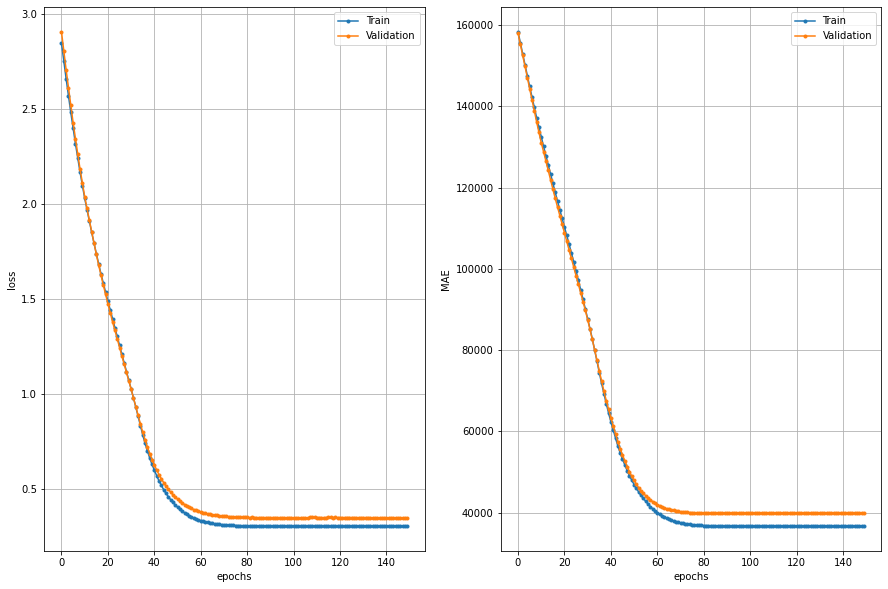

In [13]:
def plot_history(history):
    h = history.history
    epochs = range(len(h['loss']))

    plt.subplot(121), plt.plot(epochs, h['loss'], '.-', epochs, h['val_loss'], '.-')
    plt.grid(True), plt.xlabel('epochs'), plt.ylabel('loss')
    plt.legend(['Train', 'Validation'])
    plt.subplot(122), plt.plot(epochs, np.array(h['mean_absolute_error'])*1e5, '.-',
                               epochs, np.array(h['val_mean_absolute_error'])*1e5, '.-')
    plt.grid(True), plt.xlabel('epochs'), plt.ylabel('MAE')
    plt.legend(['Train', 'Validation'])
        
    print('Train MAE     ', h['mean_absolute_error'][-1]*1e5)
    print('Validation MAE', h['val_mean_absolute_error'][-1]*1e5)
    
plot_history(history)

We see that the model makes an estimation error of almost 40 000 USD. That's quite a lot but have in mind that we have only used the living area as the parameter and a model of only one neuron. In fact, what does this model do? Let's print what the model has learnt.

In [14]:
model.layers[0].get_weights()

[array([[0.5469911]], dtype=float32), array([1.8041238], dtype=float32)]

Let's now run the model to predict the value of a random house.

In [15]:
idx = 50
pred = model.predict(x_test.iloc[[idx]])
print(pred, y_test[idx])

[[1.1569985]] 1.29


### Let's Improve the Model

Given that the model is extremely simple, the performance is not that bad. But we shall be able to do better. Therefore, let's try to use more attributes and a bigger network.

First, we are going to use (as inputs) more attributes (or features) for price estimation. Let's consider, for instance, the following ones:
* **OverallQual**
 * Rates the overall material and finish of the house
* **GrLivArea**
 * Above grade (ground) living area square feet
* **GarageCars**
 * Size of garage in car capacity
* **FullBath**
 * Full bathrooms above grade
* **YearBuilt**
 * Original construction date

#### Data Preparation

As we did before, we are going to prepare the data but this time with all 5 attributes (features). For simplicity, we are going to use the `StandardScaler` from `sklearn`. But don't worry, it does exactly the same thing as we did before, it's just easier to use for multi-dimensional data :-)

In [16]:
features = ['SalePrice','OverallQual', 'GrLivArea', 'GarageCars', 'FullBath', 'YearBuilt']
data = dataset[features]

# Filling nan with the mean of the column:
data = data.fillna(data.mean())

# Extract input values and normalize
x = data[features[1:]]
scale = StandardScaler()
x = scale.fit_transform(x)

# Extract output values (prices) and normalize
y = data[features[0]].values
y = y/100000

# Split into 75% for train and 25% for test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

#### Building the Network

We are going to use the same 1-layer network. But remember, since we have now 5 features as inputs, the network (neuron in this case) makes a linear combination of all of them and adds the bias. Therefore, we have now 6 learnable (trainable) parameters, i.e. 5 weights plus bias.

In [17]:
model = Sequential()
model.add(Dense(1, input_dim=x.shape[1], activation='relu'))
model.compile(optimizer ='adam', loss = 'mean_squared_error',  metrics =[metrics.mae])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 6         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________


#### Training the Network

We changed the data but the interface stays the same. Running the training is exactly the same as before!

Train MAE      26056.119799613953
Validation MAE 27349.480986595154


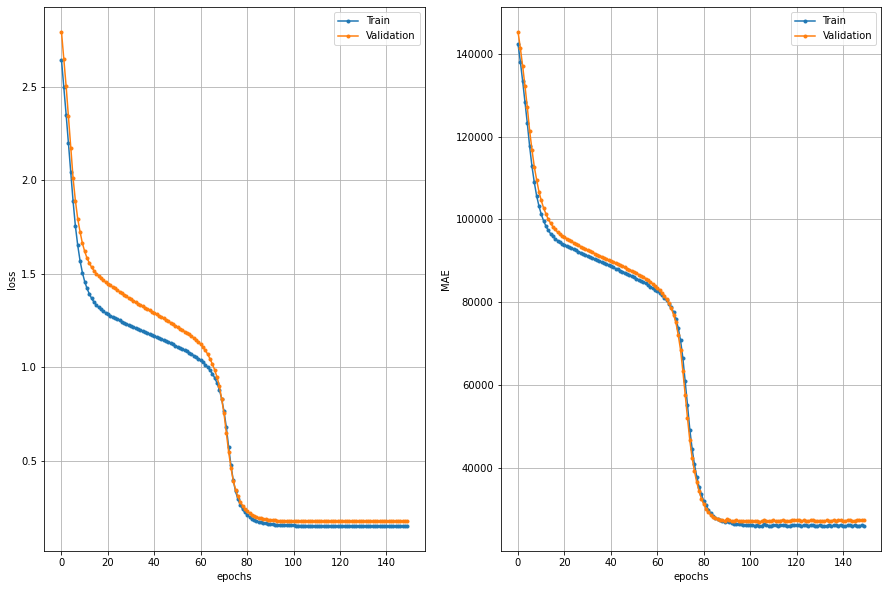

In [18]:
history = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=150, batch_size=32, verbose=0)
plot_history(history)

Let's also see what the network has learnt about the feature relevance.

In [19]:
print(features[1:])
print(model.layers[0].get_weights())

['OverallQual', 'GrLivArea', 'GarageCars', 'FullBath', 'YearBuilt']
[array([[ 0.32690158],
       [ 0.32420683],
       [ 0.12161174],
       [-0.05362175],
       [ 0.12513442]], dtype=float32), array([1.8047568], dtype=float32)]


### Keras Functional API

Besides the Sequential API that we have been using so far, Keras also offers a different way to define the models. The Functional API is in general more verstile and it allows for branching (which the Sequential does not). In order to use the Functional API, we need to make two more imports (note that we don't need to import the Sequential anymore).

In [20]:
from tensorflow.keras.layers import Input
from tensorflow.keras import Model

#### Deep Neural Network

Let's now build our fisr deep neural network (DNN). Still a very simple one but consisting of 2 layers.

In [21]:
inputs = Input(shape=x.shape[1])
outputs = Dense(5, activation='relu')(inputs)
outputs = Dense(1, activation='linear')(outputs)
model = Model(inputs, outputs)

model.compile(optimizer ='adam', loss ='mean_squared_error', metrics =[metrics.mae])
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 36
Trainable params: 36
Non-trainable params: 0
_________________________________________________________________


Train MAE      24445.098638534546
Validation MAE 26767.167448997498


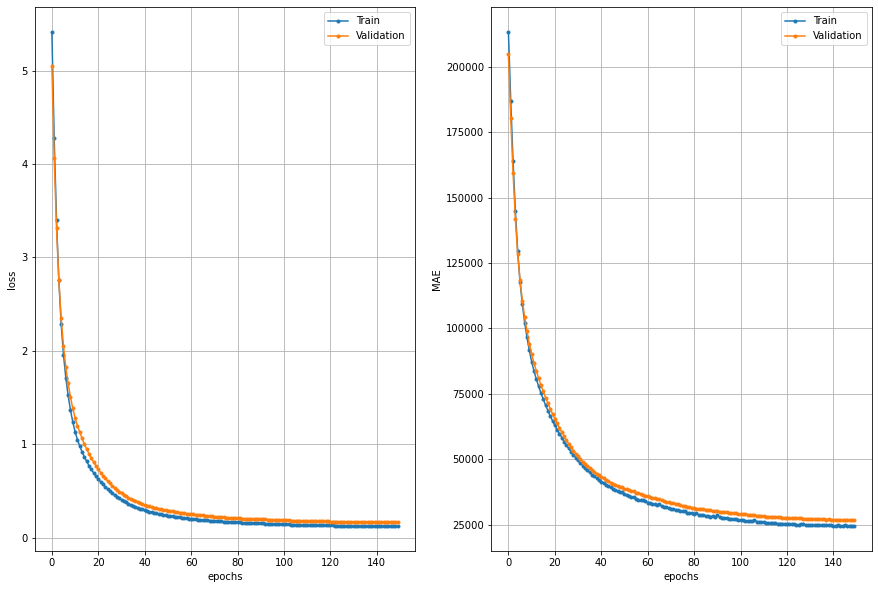

In [22]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=150, batch_size=32, verbose=0)
plot_history(history)